# Klasyfikacja obrazów metodą Vision Transformer


## Wstęp
Opracowane na podstawie:
*  [Vision Transformer (ViT) model, Alexey Dosovitskiy i inni ](https://arxiv.org/abs/2010.11929)
*  [Image classification with Vision Transformer, Khalid Salama](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

* [Vision Transformers for Brain Tumor classification, 
RAAGULBHARATWAJ K ](https://www.kaggle.com/code/raagulbharatwajk/vision-transformers-for-brain-tumor-classification)

Model ViT korzysta z architektury Transformer z funkcją self-attention, bez użycia warstw konwolucyjnych.


## Instalacja i import bibliotek

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#rozdział datset na test, train, val
import splitfolders
splitfolders.ratio("/content/gdrive/MyDrive/Colab Notebooks/Spl_data_jpg/", 
                   output="/content/gdrive/MyDrive/Colab Notebooks/Spp_data/", 
                   seed=42, 
                   ratio=(.8,0.0,.2), 
                   group_prefix=None, 
                   move=False 

In [ ]:
# przepisanie zdjęć do folderów
t_dir = "/content/gdrive/MyDrive/Colab Notebooks/Data/HSIL"
trainPaths = sorted(list(paths.list_images(t_dir)))
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
x_train = []
y_train = []
image_size = 256
a = 0

for imagePath in trainPaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    cv2.imwrite("/content/gdrive/MyDrive/Colab Notebooks/Spl_data_jpg/NSIL/s%d.jpg" % a, image)
    a+=1 

In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 48.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import sklearn.model_selection as sk
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imutils import paths
import random
from tqdm import tqdm
from google.colab import drive
import cv2
import os
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from keras.utils import plot_model



/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Przygotowanie danych

In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/Data/"
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
labels = {'HSIL':0,'LSIL':1,'NSIL':2}
train_dir = "/content/gdrive/MyDrive/Colab Notebooks/Spp_data/train"
test_dir = "/content/gdrive/MyDrive/Colab Notebooks/Spp_data/test"
trainPaths = sorted(list(paths.list_images(train_dir)))
testPaths = sorted(list(paths.list_images(test_dir)))
random.seed(2)
random.shuffle(trainPaths)
random.shuffle(testPaths)
print(f"Train Data: {len(trainPaths)}")
print(f"Test Data: {len(testPaths)}")

Train Data: 733
Test Data: 185


In [ ]:
x_train = []
y_train = []
image_size = 256
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(labels[i])
        
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(labels[i])
        
x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 94/94 [00:00<00:00, 353.95it/s]


In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=101)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train, test_size=0.2,random_state=101)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=101) # 0.125 x 0.8 = 0.2

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_test shape: {x_val.shape} - y_test shape: {y_val.shape}")


x_train shape: (734, 256, 256, 3) - y_train shape: (734,)
x_test shape: (184, 256, 256, 3) - y_test shape: (184,)


## Konfiguracja parametrów

In [ ]:
num_epochs = 100
num_classes = 3
input_shape = (256, 256, 3)
buffer_size = 512
batch_size = 256
image_size = 72 # rozmiar zdjęć używanych w augmentacji
patch_size = 6 # rozmiar pól wyodrębnianych z obrazu
num_patches = (image_size // patch_size) ** 2
learning_rate = 0.001
weight_decay = 0.0001
layer_norm_eps = 1e-6
transformer_layers = 8
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
] 
transformer_layers = 8
mlp_head_units = [2048, 1024]

## Augmentacja danych

In [ ]:
train_data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="train_data_augmentation",
)

test_data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="test_data_augmentation",
)

train_data_augmentation.layers[0].adapt(x_train)
test_data_augmentation.layers[0].adapt(x_train)

In [ ]:
def map_fn_train(image, label):
    return (train_data_augmentation(image), label)

def map_fn_test(image, label):
    return (test_data_augmentation(image), label)

In [ ]:
AUTO = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_iterator = train_ds.as_numpy_iterator()
batch = train_ds_iterator.next()
train_ds = train_ds.shuffle(buffer_size).batch(batch_size).map(map_fn_train).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(batch_size).map(map_fn_test).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(batch_size).map(map_fn_test).prefetch(AUTO)

## Perceptron wielowarstwowy (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Utworzenie pól (patches) jako warstwy

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        vanilla=False,
    ):
        super().__init__()
        self.vanilla = vanilla 
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=layer_norm_eps)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "vanilla": self.vanilla,
            "image_size": self.image_size,
            "patch_size": self.patch_size,
            "half_patch": self.half_patch
        })
        return config
    
    def crop_shift_pad(self, images, mode):
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch
        
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size-self.half_patch,
            target_width=self.image_size-self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1
            )
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            tokens = self.projection(flat_patches)
        return (tokens, patches)

Utworzone pola na przykładowym obrazie

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


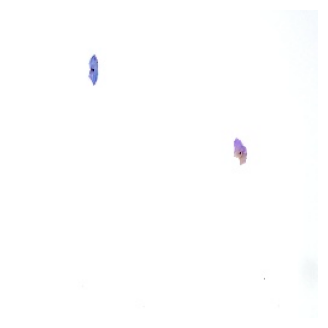

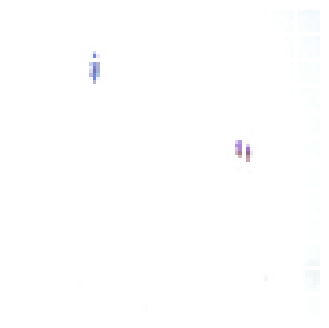

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Warstwa "kodowania" pól (patches)

Warstwa `PatchEncoder` liniowo przekształca pole (patch) poprzez rzutowanie na
wektor o rozmiarze `projection_dim`.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches=num_patches, projection_dim=projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "positions": self.positions.numpy(),
        })
        return config

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(
            math.sqrt(float(self._key_dim)),
            trainable=True
        )
        diag_attn_mask = 1 - tf.eye(num_patches)
        self.diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "tau": self.tau.numpy(),
            "diag_attn_mask": self.diag_attn_mask.numpy(),
        })
        return config

    def _compute_attention(
        self,
        query,
        key,
        value,
        attention_mask=None,
        training=None
    ):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask=self.diag_attn_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

## Model ViT

Model ViT składa się z wielu bloków Transformer,
które wykorzystują warstwę `layers.MultiHeadAttention` jako mechanizm self-attention zastosowany do sekwencji pól (patches). Bloki Transformer wytwarzają
`[batch_size, num_patches, projection_dim]` tensor, który jest przetwarzany przez algorytm głowicy klasyfikatora z softmax w celu uzyskania ostatecznego wyniku prawdopodobieństwa klasy.


In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=(image_size, image_size, 3), name="input_layer")
    (tokens, _)  = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    encoded_patches = PatchEncoder()(tokens)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes, name="output_dense", activation = 'softmax')(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## Komplicja, trenowanie i testowanie modelu

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
def run_experiment(model):
    total_steps = int((len(x_train) / batch_size) * num_epochs)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=learning_rate,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    history = model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=[tensorboard_callback]
    )
    _, accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history

In [ ]:
def testing(model):
  pre = Precision()
  re = Recall()
  acc = SparseCategoricalAccuracy()
  pred = []
  for batch in test_ds.as_numpy_iterator(): 
    X, y = batch
    yhat = np.argmax(model.predict(X), axis=1)
    pred.append(yhat)
    xy=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, xy)

  pred = np.array(pred)
  pred = pred.reshape((pred.size,))
  print(accuracy_score(y_test, pred))
  ConfusionMatrixDisplay.from_predictions(y_test, pred)
  tf.keras.utils.plot_model(model,show_shapes=True)
  print(classification_report(y_test, pred, target_names=labels))


In [ ]:
#tf.keras.utils.plot_model(vit_sl,show_shapes=True)

6/6 [==============================] - 3s 521ms/step
tf.Tensor(0.7118644, shape=(), dtype=float32) tf.Tensor(0.9692308, shape=(), dtype=float32) tf.Tensor(0.4728261, shape=(), dtype=float32)
0.47282608695652173
              precision    recall  f1-score   support

        HSIL       0.43      0.06      0.10        54
        LSIL       0.48      0.21      0.29        47
        NSIL       0.47      0.89      0.62        83

    accuracy                           0.47       184
   macro avg       0.46      0.39      0.34       184
weighted avg       0.46      0.47      0.38       184



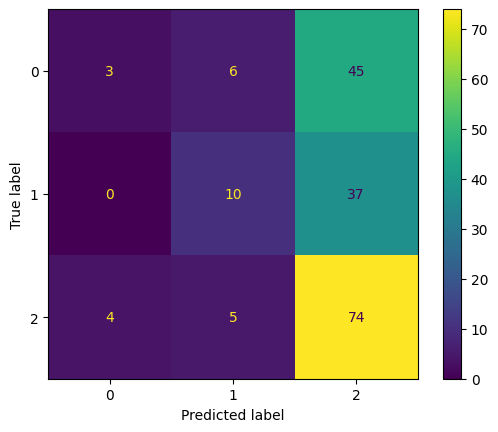

In [ ]:
testing(vit_sl)

In [ ]:
image_path = "/content/gdrive/MyDrive/Colab Notebooks/Data/NSIL/pow. 40/1b.bmp"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(72, 72))
image = tf.keras.preprocessing.image.img_to_array(image)
image =  np.expand_dims(image, 0)
yp = vit_sl.predict(image)
print(yp)

1/1 [==============================] - 0s 114ms/step
[[0.20321299 0.2593461  0.53744096]]


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 16s 1s/step - loss: 9.9051 - accuracy: 0.4252 - val_loss: 3.2940 - val_accuracy: 0.2174
Epoch 2/100
3/3 [==============================] - 2s 646ms/step - loss: 5.3863 - accuracy: 0.3302 - val_loss: 2.6264 - val_accuracy: 0.5652
Epoch 3/100
3/3 [==============================] - 2s 669ms/step - loss: 2.9790 - accuracy: 0.4735 - val_loss: 2.1172 - val_accuracy: 0.3152
Epoch 4/100
3/3 [==============================] - 3s 883ms/step - loss: 1.9567 - accuracy: 0.4470 - val_loss: 1.0595 - val_accuracy: 0.4565
Epoch 5/100
3/3 [==============================] - 2s 639ms/step - loss: 1.6113 - accuracy: 0.4548 - val_loss: 0.9239 - val_accuracy: 0.5761
Epoch 6/100
3/3 [==============================] - 2s 702ms/step - loss: 1.2778 - accuracy: 0.4766 - val_loss: 1.2288 - val_accuracy: 0.3478
Epoch 7/100
3/3 [==============================] - 2s 671ms/step - loss: 1.2239 - accuracy: 0.4813 - val_loss: 0.9563 - val_accuracy: 0.5761
Epoch 8/100
3/3 [==========

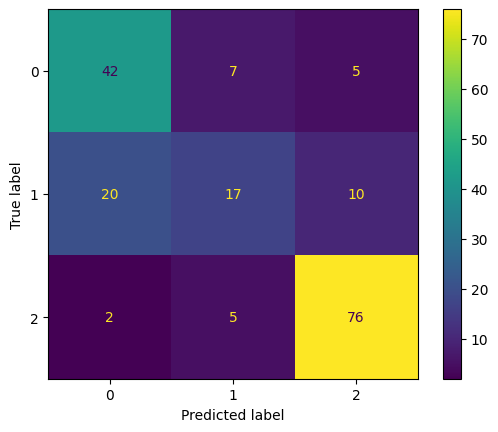

In [ ]:
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)
testing(vit_sl)

In [ ]:
vit_sl.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 shifted_patch_tokenization_6 (  ((None, 144, 64),   35704       ['input_layer[0][0]']            
 ShiftedPatchTokenization)       (None, 12, 12, 540                                               
                                ))                                                                
                                                                                                  
 patch_encoder_6 (PatchEncoder)  (None, 144, 64)     9216        ['shifted_patch_tokenization_6[0]
                                                                 [0]']                      